In [ ]:
#|default_exp peak_pattern_atlas 

# Peak pattern atlas 

> The forest and the trees

Given our ability to generate theoretical XRF spectra we can now build an atlas of spectral peak patterns for different chemical elements. In the following we will ignore the exotic Lanthanides and Actinides and further limit our attention to what I call the *Elements Of Interest*. To plot the periodic table instantiate the `PeriodicTable` class and run the `.plot()` method. The edges of pre-selected elements of interest (to me) are colored red.      

In [1]:
from moseley import PeriodicTable, PeakPatternAtlas

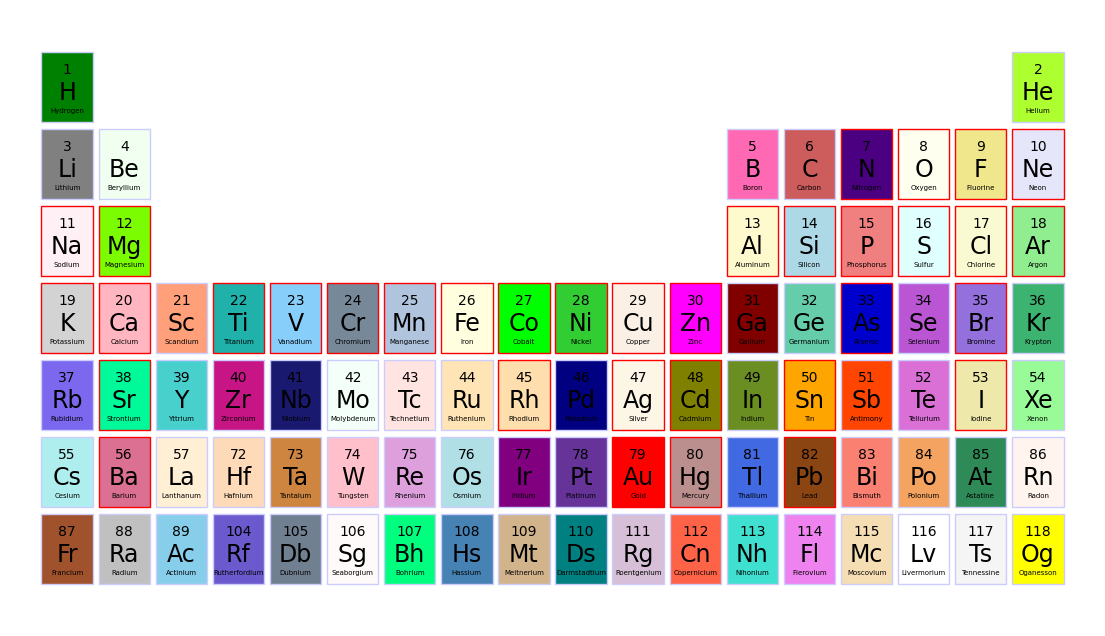

In [2]:
table = PeriodicTable()
table.plot();

We are now in a position to compute our atlas of elemental XRF peak patterns...

In [43]:
ppa = PeakPatternAtlas() 

Ready building Peak Pattern Atlas!                                                                   


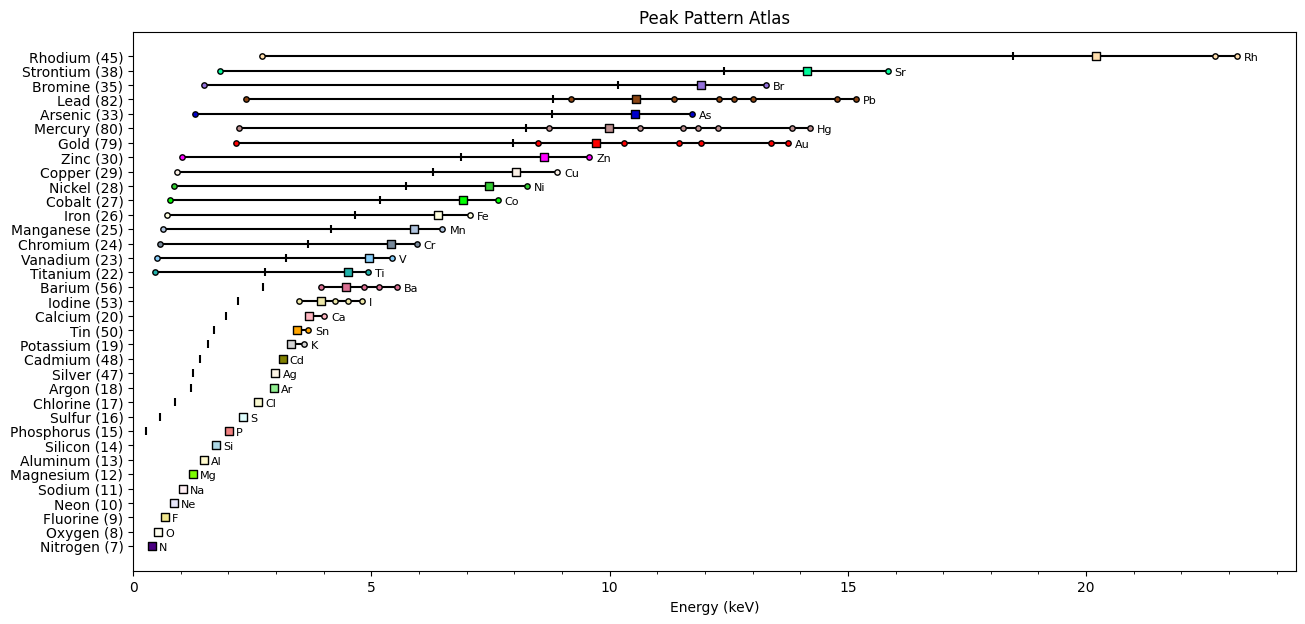

In [45]:
ax = ppa.plot_atlas()

## FUNCTIONS 

In [19]:
#|export 

# Periodic Table 
import mendeleev as mv 
from mendeleev.fetch import fetch_table  

import moseley as mos 

# plotting 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import matplotlib.colors as mcolors 


In [42]:
#|export 

class PeakPatternAtlas():
    '''Create a PeakPatternAtlas instance. '''

    def __init__(self, EOI=None, excitation_energy_keV=25, verbose=True):
        '''Compute Peak Pattern Atlas for `excitation_energy_keV=25`.'''

        self.table = mos.PeriodicTable(EOI=EOI)

        self.EOI = [element for element in self.table.EOI if not '#'in element]
        
        self.element_xrf_list = [] 
        self.ptrn_dict_list = []

        for i, element in enumerate(self.EOI):     
            if verbose: 
                print(f'Please wait while computing spectral pattern for element {i+1}/{len(self.EOI)}...', end='\r') 

                element_xrf = mos.ElementXRF(element, excitation_energy_keV=excitation_energy_keV)
                ptrn_dict = element_xrf.get_pattern_dict()

                self.element_xrf_list.append(element_xrf)
                self.ptrn_dict_list.append(ptrn_dict)
                
        #self.element_xrf_list = [mos.ElementXRF(elem, excitation_energy_keV=excitation_energy_keV) for elem in self.EOI] 
        #self.ptrn_dict_list = [element_xrf.get_pattern_dict() for element_xrf in self.element_xrf_list]
        if verbose: 
            print('Ready building Peak Pattern Atlas!                                                                   ') 
      

    def plot_atlas(self, order='alpha', moseley=False, colorize_elements='all', ax=None): 

        if ax is None: 
            fig, ax = plt.subplots(figsize=[15, 7])
            ax.set_title('Peak Pattern Atlas')

        ptrn_dict_list = _sort_ptrn_list(self.ptrn_dict_list, order=order)
        
        n_ptrns = len(ptrn_dict_list)

        yticks = []
        ytick_labels = []
        for i, ptrn_dict in enumerate(ptrn_dict_list): 
            elem = ptrn_dict['elem']
            name = ptrn_dict['name']
            Z = ptrn_dict['atomic_number'] 
            
            if colorize_elements == 'all':
                color = self.table.element_colors_dict[elem]
            elif elem in colorize_elements: 
                color = self.table.element_colors_dict[elem]
            else: 
                color = None
        
            ytick_labels.append(f'{name} ({Z})')

            if moseley: 
                offset = Z 
            else: 
                offset = i 
                
            yticks.append(offset) 
            mos.plot_pattern(ptrn_dict, ax=ax, offset=offset, color=color) 
        
        ax.set_yticks(yticks) 
        ax.set_yticklabels(ytick_labels)
        ax.set_xlabel('Energy (keV)')
        ax.set_xlim(xmin=0)
        ax.set_xticks(range(25), minor=True);
    

        return ax 

def _fetch_table(): 
    '''Utility function wrapper for mendeleev periodic table data.  
    
    Make dataframe with selected element attributes for regular part of the periodic table.
    The irregular Lanthanides and Actinides series are rare, so we do not plot them. 
    
    Returns: ptable_regular (dataframe) 
    '''
    
    #ptable_df = mv.get_table('elements') # mendeleev 0.5 
    ptable_df = fetch_table('elements')
    ptable = ptable_df[['atomic_number', 'symbol', 'name', 'group_id', 'period']]
    is_regular = ~np.isnan(ptable_df['group_id'].values)

    ptable_regular = ptable[is_regular]
    
    return ptable_regular 


def colorize(ptable_regular): 
    '''Generate regular element colors dictionary. 
    
    Returns: element_colors_dict '''
    
    n_regular = len(ptable_regular) # 90 rows 
    
    # see: https://matplotlib.org/stable/gallery/color/named_colors.html 
    css4_dict = mcolors.CSS4_COLORS 
        
    # hack to select brightest colors and exclude american double grays 
    css4_names = list(css4_dict.keys()) 
    css4_names = sorted(sorted(css4_names, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))) # brightest colors 
    css4_names = [name for name in css4_names if 'gray' not in name] # exclude doubles grays 

    # pick brightest 90 
    n_names = len(css4_names) 
    css4_names = css4_names[n_names - n_regular - 1:n_names - 1]

    element_colors_dict = dict(zip(ptable_regular['symbol'], css4_names))

    return element_colors_dict


def _draw_box(ax, element_attrs, edgecolor=None, facecolor=None):
    '''Draw a box for element *element_attrs*  in subplot *ax*. '''
    
    w = 0.9
    h = 0.9
    
    atomic_number, symbol, name, x, y = element_attrs 
    
    if edgecolor is None: 
        edgecolor = [0.8, 0.8, 1.0]
        
    if facecolor is None: 
        facecolor = [0.95, 0.95, 1.0]
    
    rect = mpatches.Rectangle([x - w/2, y - h/2], h, w, edgecolor=edgecolor, facecolor=facecolor)
    ax.add_patch(rect)
    
    ax.annotate(symbol, [x, y], xytext=[0, -4], textcoords='offset points',
                va='center', ha='center', fontsize=17)
    
    ax.annotate(atomic_number, [x, y], xytext=[0, 12], textcoords='offset points', 
                va='center', ha='center', fontsize=10)
    
    ax.annotate(name, [x, y], xytext=[0, -17], textcoords='offset points',
                va='center', ha='center', fontsize=5)


def _sort_ptrn_list(ptrn_dict_list, order='alpha'): 
    '''Utility function to sort ptrn_dict_list in 'alpha' or 'Z' order. 
    
    Returns: sorted_ptrn_list '''

    if order == 'alpha': 
        alpha_list = [ptrn['alpha_keV'] for ptrn in ptrn_dict_list]
        idxs = np.argsort(alpha_list)
    elif order == 'Z': 
        Z_list = [ptrn['atomic_number'] for ptrn in ptrn_dict_list] 
        idxs = np.argsort(Z_list)
        
    sorted_ptrn_list = [ptrn_dict_list[i] for i in idxs]  
        
    return sorted_ptrn_list


class PeriodicTable(): 
    '''Create a periodic table of elements. '''
    
    
    def __init__(self, EOI=None): 

        if EOI is None: 
            self.EOI = ['#H', '#He', '#Li', '#Be', '#B', '#C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 
                        'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', '#Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 
                        'Co', 'Ni', 'Cu', 'Zn', '#Ga', '#Ge', 'As', '#Se', 'Br', '#Kr', '#Rb', 'Sr', 
                        '#Y', '#Zr', '#Nb', '#Mo', '#Tc', '#Ru', 'Rh', '#Pd', 'Ag', 'Cd', '#In', 'Sn', 
                        '#Sb', '#Te', 'I', '#Xe', '#Cs', 'Ba', '#La', '#Hf', '#Ta', '#W', '#Re', '#Os', 
                        '#Ir', '#Pt', 'Au', 'Hg', '#Tl', 'Pb', '#Bi', '#Po', '#At', '#Rn', '#Fr', '#Ra', 
                        '#Ac', '#Rf', '#Db', '#Sg', '#Bh', '#Hs', '#Mt', '#Ds', '#Rg', '#Cn', '#Nh', 
                        '#Fl', '#Mc', '#Lv', '#Ts', '#Og']    
        else: 
            self.EOI = EOI 
     
    
        # fetch regular part of periodic table 
        self.ptable_regular = _fetch_table() 
    
        # generate element colors dict 
        self.element_colors_dict = colorize(self.ptable_regular) 


    def plot_table(self, ax=None, figname=None): 
        '''Create periodic table plot with selected elements colorized.'''
    
        if ax is None: 
            fig, ax = plt.subplots(figsize=[14, 8])
        else: 
            fig = ax.get_figure()
            
        ax.invert_yaxis()
    
        for i, element_attrs in enumerate(self.ptable_regular.values): 
    
            atomic_number, symbol, name, x, y = element_attrs 
            facecolor = self.element_colors_dict[symbol] 
            
            if symbol in self.EOI: 
                edgecolor = 'r' 
            else: 
                edgecolor = None
            _draw_box(ax, element_attrs, edgecolor=edgecolor, facecolor=facecolor)
    
        ax.set_xlim(0, 19)
        ax.set_ylim(8, 0)
        ax.axis('off');
        
        if figname is not None: 
    
            fig.savefig(figname)
    
        return ax